<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_07_04_survival_analysis_svm_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.7.4 Support Vector Machine (SVM)  Survival Model  


This section covers **Support Vector Machine (SVM)-based survival analysis**, including its concepts, advantages, limitations, and a practical R tutorial using the  `survivalsvm` package.


## Overview


**Support Vector Machine (SVM)-Based Survival Analysis** is a machine learning approach that adapts the  `Support Vector Machine` framework—originally designed for classification and regression—to `survival analysis` problems. Survival analysis deals with **time-to-event data**, where the outcome of interest is the time until an event occurs (e.g., death, machine failure, customer churn), and data is often 1censored** (i.e., the event has not occurred for some subjects by the end of the study).

Traditional survival models like `Cox Proportional Hazards` are parametric or semi-parametric and make strong assumptions (e.g., proportional hazards). SVM-based survival analysis offers a `non-parametric, non-linear, and robust alternative` using the `maximum margin principle** of SVMs.


### Key Concepts


| Concept | Explanation |
|--------|-------------|
| **Survival Data** | $(t_i, \delta_i, \mathbf{x}_i)$: <br> - $t_i$: observed time (event or censoring) <br> - $\delta_i = 1$ if event occurred, $0$ if censored <br> - $\mathbf{x}_i$: feature vector |
| **Censoring** | Right-censoring: event not observed during study (common) |
| **Goal** | Rank subjects by risk or predict survival probability |



### How SVM is Adapted for Survival Analysis


There are two main formulations:


#### Ranking-Based SVM (Survival SVM) (Most common: e.g., Van Belle et al., 2011)


Instead of predicting exact survival times, **rank patients by their risk** — those likely to experience the event **sooner** should have **higher risk scores**.

Learn a function $f(\mathbf{x})$ such that for any uncensored pair $(i, j)$ where $t_i < t_j$ and $\delta_i = 1$, we have:

$$
f(\mathbf{x}_i) > f(\mathbf{x}_j)
$$

(i.e., higher risk for earlier event)


For every pair where subject $i$ fails before subject $j$ (and $i$ is not censored):

$$
f(\mathbf{x}_i) \geq f(\mathbf{x}_j) + 1 - \xi_{ij}
$$

with slack $\xi_{ij} \geq 0$

Optimization Problem:

$$
\min_{w, b, \xi} \ \frac{1}{2} \|w\|^2 + C \sum \xi_{ij}
$$
subject to ranking constraints only on **comparable pairs** (uncensored earlier events).

This is solved via **quadratic programming** or specialized algorithms.


####  Regression-Based SVM (SVR for Survival) (e.g., Shivaswamy et al., 2007)



Treat survival time as a regression target, but:

- **Censored points** provide **lower bounds** (event time $> t_i$)
- Use **asymmetric loss** (like in survival SVR)


Loss Function:
- For uncensored: standard $\epsilon$-insensitive loss
- For censored: only penalize if prediction is **below** observed time



### Advantages of SVM-Based Survival Analysis


| Advantage | Description |
|---------|-------------|
| **Non-parametric** | No assumption on survival distribution |
| **Handles non-linearity** | Via kernel trick (RBF, polynomial) |
| **Robust to outliers** | Due to margin maximization |
| **Handles high-dimensional data** | Like gene expression data |
| **Censoring-aware** | Built into the model |


### Limitations


| Limitation | Explanation |
|----------|-------------|
| **Scalability** | $O(n^2)$ comparable pairs → slow for large $n$ |
| **No direct probability output** | Gives risk score, not $S(t)$ |
| **Hard to interpret** | Like standard SVMs |
| **Requires careful censoring handling** | Only right-censoring typically |



### Practical Use Cases


- **Cancer prognosis** using genomic data
- **Predicting machine failure** in predictive maintenance
- **Customer churn modeling** in business



### Comparison with Cox Model


| Feature | Cox PH | SVM Survival |
|-------|--------|--------------|
| Assumption | Proportional hazards | None |
| Output | Hazard ratios | Risk ranking |
| Non-linearity | No (unless engineered) | Yes (kernel) |
| Censoring | Yes | Yes |
| Interpretability | High | Low |



## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316571 sha256=f9121ae497ced3d882fae20f76e3d20a551352e109a65ff9ae777951613ccf89
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [2]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## SVM-Based Survival Analysis from Scratch


This section implements a simple **ranking-based Survival SVM** using **Stochastic Gradient Descent (SGD)** in R from scratch.


###  Ranking Hinge Loss


Ranking-based SVM for survival analysis focuses on correctly ordering patients by risk.

For every **comparable pair** $(i, j)$ where:

- Patient $j$ had an **event** $`event[j] == 1`$
- Patient $i$ survived **longer** than $j$ $`time[i] > time[j]`$

We want the model’s risk score to satisfy:  

$$
f(x_i) \geq f(x_j) + 1
$$

We penalize violations using **hinge loss**:  
$$
\mathcal{L}_{ij} = \max\left(0,\ 1 - \big(f(x_i) - f(x_j)\big)\right)
$$

With linear model \(f(x) = w^\top x\), total loss is:  
$$
\mathcal{L}(w) = \frac{\lambda}{2} \|w\|^2 + \frac{1}{|P|} \sum_{(i,j) \in P} \max\left(0,\ 1 - w^\top(x_i - x_j)\right)
$$

We minimize this via **SGD**.



### Generate Comparable Pairs (Once)

In [3]:
%%R
generate_comparable_pairs <- function(time, event) {
  n <- length(time)
  pairs <- list()
  k <- 1
  for (i in 1:n) {
    for (j in 1:n) {
      if (event[j] == 1 && time[i] > time[j]) {
        pairs[[k]] <- c(i = i, j = j)
        k <- k + 1
      }
    }
  }
  if (k == 1) return(NULL)
  do.call(rbind, pairs)
}

### SGD-Based Survival SVM Trainer

In [4]:
%%R
survivalsvm_sgd <- function(X, time, event,
                            lambda = 0.01,      # L2 penalty (lambda = 1/C)
                            lr = 0.01,          # learning rate
                            epochs = 100,
                            verbose = TRUE) {

  # Input checks
  stopifnot(is.matrix(X) || is.data.frame(X))
  X <- as.matrix(X)
  n <- nrow(X); p <- ncol(X)

  # Generate comparable pairs
  pairs <- generate_comparable_pairs(time, event)
  if (is.null(pairs)) stop("No comparable pairs found!")
  m <- nrow(pairs)

  if (verbose) cat("Number of comparable pairs:", m, "\n")

  # Initialize weights (small random)
  set.seed(1)
  w <- rnorm(p, mean = 0, sd = 0.01)

  # Precompute feature differences for all pairs (memory vs speed trade-off)
  # X_diff[k, ] = X[i, ] - X[j, ] for pair k = (i, j)
  X_diff <- matrix(0, nrow = m, ncol = p)
  for (k in 1:m) {
    i <- pairs[k, "i"]
    j <- pairs[k, "j"]
    X_diff[k, ] <- X[i, ] - X[j, ]
  }

  # SGD loop
  for (epoch in 1:epochs) {
    # Shuffle pair indices
    idx <- sample(m)

    total_loss <- 0

    for (k in idx) {
      diff <- X_diff[k, ]              # x_i - x_j
      margin <- sum(w * diff)          # w^T (x_i - x_j)
      loss <- max(0, 1 - margin)       # hinge loss

      total_loss <- total_loss + loss

      # Gradient update
      if (margin < 1) {
        # Subgradient: - (x_i - x_j)
        grad_w <- lambda * w - diff
      } else {
        # Only L2 regularization gradient
        grad_w <- lambda * w
      }

      # SGD step
      w <- w - lr * grad_w
    }

    avg_loss <- total_loss / m
    if (verbose && epoch %% 20 == 0) {
      cat("Epoch", epoch, "| Avg Loss:", round(avg_loss, 4), "\n")
    }
  }

  list(
    weights = w,
    n_epochs = epochs,
    lambda = lambda,
    lr = lr,
    n_pairs = m
  )
}

### Prediction Function

In [5]:
%%R
predict_survivalsvm_sgd <- function(model, newdata) {
  newdata <- as.matrix(newdata)
  as.vector(newdata %*% model$weights)
}

### Manual C-index (Harrell’s Concordance)

In [6]:
%%R
compute_cindex <- function(risk, time, event) {
  n <- length(risk)
  concordant <- 0
  usable <- 0

  for (i in 1:(n-1)) {
    for (j in (i+1):n) {
      # Only consider pairs where at least one had an event
      if (event[i] == 1 || event[j] == 1) {
        # Only comparable if times are unequal
        if (time[i] != time[j]) {
          usable <- usable + 1
          # Concordant if higher risk = shorter survival
          if ((risk[i] > risk[j] && time[i] < time[j]) ||
              (risk[i] < risk[j] && time[i] > time[j])) {
            concordant <- concordant + 1
          }
          # Ties in risk: add 0.5 (optional, skipped here for simplicity)
        }
      }
    }
  }

  if (usable == 0) return(NA)
  concordant / usable
}

### Example


We’ll manually include the `veteran` data as a data frame



In [7]:
%%R
# Simulate small survival data (base R only)
set.seed(42)
n <- 50
p <- 3
X <- matrix(rnorm(n * p), nrow = n)
colnames(X) <- c("x1", "x2", "x3")

# True risk = x1 + 0.5*x2
true_risk <- X[,1] + 0.5 * X[,2]
# Generate survival time ~ exp(-risk)
time <- rexp(n, rate = exp(true_risk))
# Event: 80% events, 20% censoring
event <- rbinom(n, 1, 0.8)

# Fit Survival SVM via SGD
model_sgd <- survivalsvm_sgd(
  X, time, event,
  lambda = 0.1,
  lr = 0.05,
  epochs = 100,
  verbose = TRUE
)

# Predict
risk_pred <- predict_survivalsvm_sgd(model_sgd, X)

# Evaluate
cindex <- compute_cindex(risk_pred, time, event)
cat("\nFinal C-index:", round(cindex, 3), "\n")

# Compare to true risk
cat("C-index (true risk):", round(compute_cindex(true_risk, time, event), 3), "\n")

Number of comparable pairs: 1034 
Epoch 20 | Avg Loss: 0.596 
Epoch 40 | Avg Loss: 0.5989 
Epoch 60 | Avg Loss: 0.5932 
Epoch 80 | Avg Loss: 0.5974 
Epoch 100 | Avg Loss: 0.5964 

Final C-index: 0.235 
C-index (true risk): 0.747 


## SVM-Based Survival Analysis R


This tutorial demonstrates **Support Vector Machine (SVM)-based survival analysis** in **R** using the **veteran dataset** from the `survival` package. We'll use the **`survivalsvm`** package, which implements **ranking-based survival SVM**.



### Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:


In [8]:
%%R
packages <-c(
		 'tidyverse',
	   'survivalsvm',
	   'survival',
		 'survcomp',
		 'survMisc',
		 'survminer',
		 'MASS'

		 )


### Install missing packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')


In [ ]:
%%R
install.packages("survivalsvm", lib='drive/My Drive/R/')

### Verify Installation

In [10]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
  tidyverse survivalsvm    survival    survcomp    survMisc   survminer 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
       MASS 
       TRUE 


### Load Packages

In [11]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [12]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
 [1] "package:MASS"        "package:survminer"   "package:ggpubr"     
 [4] "package:survMisc"    "package:survcomp"    "package:prodlim"    
 [7] "package:survivalsvm" "package:survival"    "package:lubridate"  
[10] "package:forcats"     "package:stringr"     "package:dplyr"      
[13] "package:purrr"       "package:readr"       "package:tidyr"      
[16] "package:tibble"      "package:ggplot2"     "package:tidyverse"  
[19] "package:tools"       "package:stats"       "package:graphics"   
[22] "package:grDevices"   "package:utils"       "package:datasets"   
[25] "package:methods"     "package:base"       


###  Load and Prepare the `veteran` Dataset


The `veteran` dataset contains survival data for lung cancer patients from the Veterans’ Administration Lung Study. It includes covariates like treatment type, cell type, Karnofsky performance score, time since diagnosis, and survival status.


In [13]:
%%R
# Load data
data(veteran)

# Inspect structure
str(veteran)
# time: survival time in days
# status: 0 = censored, 1 = dead
# trt: 1=standard, 2=test
# celltype: 1=squamous, 2=small cell, 3=adeno, 4=large
# karno: Karnofsky performance score (0–100)
# diagtime: time from diagnosis to study entry (days)
# age: age in years
# prior: 0=no, 10=yes (prior therapy)

# Convert to factor where appropriate
veteran_clean <- veteran %>%
  mutate(
    event = ifelse(status == 1, 1, 0),  # 1 = event (death), 0 = censored
    trt = factor(trt, labels = c("Standard", "Test")),
    celltype = factor(celltype, labels = c("Squamous", "Small Cell", "Adeno", "Large"))
  )

# Select relevant columns
veteran_df <- veteran_clean %>%
  dplyr::select(time, event, trt, celltype, karno, diagtime, age, prior)

# View first few rows
head(veteran_df)

'data.frame':	137 obs. of  8 variables:
 $ trt     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ celltype: Factor w/ 4 levels "squamous","smallcell",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ time    : num  72 411 228 126 118 10 82 110 314 100 ...
 $ status  : num  1 1 1 1 1 1 1 1 1 0 ...
 $ karno   : num  60 70 60 60 70 20 40 80 50 70 ...
 $ diagtime: num  7 5 3 9 11 5 10 29 18 6 ...
 $ age     : num  69 64 38 63 65 49 69 68 43 70 ...
 $ prior   : num  0 10 0 10 10 0 10 0 0 0 ...
  time event      trt celltype karno diagtime age prior
1   72     1 Standard Squamous    60        7  69     0
2  411     1 Standard Squamous    70        5  64    10
3  228     1 Standard Squamous    60        3  38     0
4  126     1 Standard Squamous    60        9  63    10
5  118     1 Standard Squamous    70       11  65    10
6   10     1 Standard Squamous    20        5  49     0


### Split Data into Training and Testing Sets

In [14]:
%%R
set.seed(123)
n <- nrow(veteran_df)
train_idx <- sample(1:n, size = 0.7 * n)
train_data <- veteran_df[train_idx, ]
test_data  <- veteran_df[-train_idx, ]

cat("Training samples:", nrow(train_data), "\n")
cat("Testing samples:", nrow(test_data), "\n")

Training samples: 95 
Testing samples: 42 


###  Fit Survival SVM Models

#### Linear-like Kernel (`add_kernel`) — Ranking SVM

In [15]:
%%R
svm_linear <- survivalsvm(
  Surv(time, event) ~ .,
  data        = train_data,
  type        = "vanbelle1",    # ranking-based SVM
  gamma       = 0.1,
  opt         = "quadprog",
  diff.meth   = "makediff3",
  kernel      = "add_kernel"    # additive (linear-like) kernel
)

print(svm_linear)



survivalsvm result

Call:
 survivalsvm(Surv(time, event) ~ ., data = train_data, type = "vanbelle1", gamma = 0.1, opt = "quadprog", diff.meth = "makediff3", kernel = "add_kernel") 

Survival svm approach                  : vanbelle1 
Type of Kernel                         : add_kernel 
Method used to build 1NN differences   : diff3 
Optimization solver used               : quadprog 
Number of support vectors retained     : 94 
survivalsvm version                    : 0.0.6 


####  RBF (Gaussian) Kernel

In [16]:
%%R
svm_rbf <- survivalsvm(
  Surv(time, event) ~ .,
  data      = train_data,
  type      = "regression",       # regression-based SVM
  gamma     = 0.05,
  opt       = "quadprog",
  kernel    = "rbf_kernel"
)
print(svm_rbf)


survivalsvm result

Call:

 survivalsvm(Surv(time, event) ~ ., data = train_data, type = "regression", gamma = 0.05, opt = "quadprog", kernel = "rbf_kernel") 

Survival svm approach              : regression 
Type of Kernel                     : rbf_kernel 
Optimization solver used           : quadprog 
Number of support vectors retained : 95 
survivalsvm version                : 0.0.6 


### Make Predictions and Evaluate Performance

In [17]:
%%R
# Re-encode factor levels in test_data to match training
for (col in names(test_data)) {
  if (is.factor(train_data[[col]])) {
    test_data[[col]] <- factor(test_data[[col]], levels = levels(train_data[[col]]))
  }
}

# Make predictions
pred_linear <- predict(svm_linear, newdata = test_data)
pred_rbf    <- predict(svm_rbf, newdata = test_data)

# Extract risk scores (ensure they are numeric vectors)
risk_linear <- as.numeric(pred_linear$predicted)
risk_rbf    <- as.numeric(pred_rbf$predicted)

# Safety check
stopifnot(length(risk_linear) == nrow(test_data))
stopifnot(length(risk_rbf) == nrow(test_data))

# Compute C-indices using NEW concordance()
cindex_linear <- concordance(Surv(time, event) ~ risk_linear, data = test_data)$concordance
cindex_rbf    <- concordance(Surv(time, event) ~ risk_rbf, data = test_data)$concordance

# Cox model
cox_model <- coxph(Surv(time, event) ~ ., data = train_data)
cox_risk  <- predict(cox_model, newdata = test_data, type = "risk")
cindex_cox <- concordance(Surv(time, event) ~ cox_risk, data = test_data)$concordance

# Print
cat("Cox C-index       :", round(cindex_cox, 3), "\n")
cat("SVM (Linear) C-index :", round(cindex_linear, 3), "\n")
cat("SVM (RBF) C-index    :", round(cindex_rbf, 3), "\n")

Cox C-index       : 0.3 
SVM (Linear) C-index : 0.432 
SVM (RBF) C-index    : 0.468 



>  Higher C-index (closer to 1.0) = better predictive discrimination.



###  Risk Stratification and Kaplan-Meier Plot (Using Linear SVM)

Ignoring unknown labels:
• linetype : "1"
Ignoring unknown labels:
• linetype : "1"
Ignoring unknown labels:
• linetype : "1"
Ignoring unknown labels:
• linetype : "1"
Ignoring unknown labels:
• colour : "SVM Risk Group"


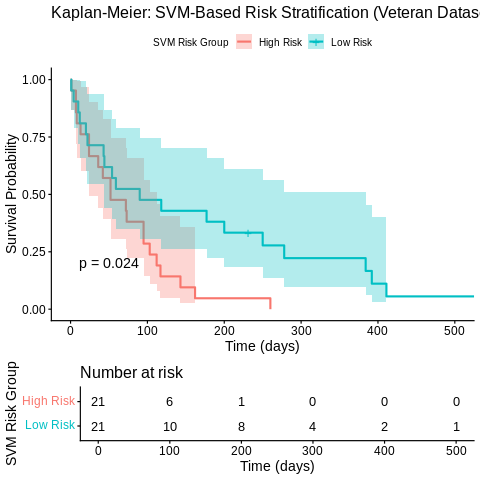

In [18]:
%%R
# Create risk groups based on median predicted risk
pred_df <- data.frame(
  time  = test_data$time,
  event = test_data$event,
  risk  = risk_linear
) %>%
  mutate(risk_group = ifelse(risk > median(risk), "High Risk", "Low Risk"))

# Fit Kaplan-Meier curves
km_fit <- survfit(Surv(time, event) ~ risk_group, data = pred_df)

# Plot
ggsurvplot(
  km_fit,
  data = pred_df,
  pval = TRUE,
  conf.int = TRUE,
  risk.table = TRUE,
  legend.title = "SVM Risk Group",
  legend.labs = c("High Risk", "Low Risk"),
  title = "Kaplan-Meier: SVM-Based Risk Stratification (Veteran Dataset)",
  xlab = "Time (days)",
  ylab = "Survival Probability"
)


>  This plot visually assesses whether the SVM risk groups separate well in terms of survival outcomes.



## Hyperparameter Tuning

### Prepare for Cross-Validation

In [19]:
%%R
set.seed(42)
k <- 5
n <- nrow(veteran_clean)
folds <- sample(rep(1:k, length.out = n))

### Define Gamma Grid for Tuning

In [20]:
%%R
gamma_grid <- c(0.001, 0.01, 0.05, 0.1, 0.5, 1.0)

### Cross-Validation Function for a Single Gamma Value


Create a function that, given a `gamma` and fold index, returns the `C-index` on the validation fold.


In [21]:
%%R
cv_survsvm_one_gamma <- function(gamma_val, fold_id, data, folds) {
  # Split
  train_idx <- which(folds != fold_id)
  val_idx   <- which(folds == fold_id)

  train_data <- data[train_idx, ]
  val_data   <- data[val_idx, ]

  # Re-align factor levels in validation set
  for (col in names(val_data)) {
    if (is.factor(train_data[[col]])) {
      val_data[[col]] <- factor(val_data[[col]], levels = levels(train_data[[col]]))
    }
  }

  # Fit Survival SVM (ranking type with add_kernel)
  svm_fit <- tryCatch({
    survivalsvm(
      Surv(time, event) ~ .,
      data = train_data,
      type = "vanbelle1",
      gamma = gamma_val,
      opt = "quadprog",
      diff.meth = "makediff3",
      kernel = "add_kernel"
    )
  }, error = function(e) {
    return(NULL)
  })

  if (is.null(svm_fit)) return(NA)

  # Predict
  pred <- predict(svm_fit, newdata = val_data)
  risk <- as.numeric(pred$predicted)

  # Safety: if prediction fails or lengths mismatch
  if (length(risk) != nrow(val_data)) return(NA)

  # Compute C-index using modern concordance()
  concord <- tryCatch({
    concordance(Surv(time, event) ~ risk, data = val_data)$concordance
  }, error = function(e) {
    return(NA)
  })

  return(concord)
}

### Perform Cross-Validation Over Gamma Grid

In [22]:
%%R
results <- tibble(gamma = gamma_grid) %>%
  dplyr::mutate(
    c_indices = map(gamma, ~ {
      current_gamma <- .x
      map_dbl(1:k, ~ cv_survsvm_one_gamma(
        gamma_val = current_gamma,
        fold_id = .x,
        data = veteran_clean,
        folds = folds
      ))
    }),
    mean_cindex = map_dbl(c_indices, ~ mean(.x, na.rm = TRUE)),
    sd_cindex   = map_dbl(c_indices, ~ sd(.x, na.rm = TRUE))
  )

# View results
print(results)

# A tibble: 6 × 4
  gamma c_indices mean_cindex sd_cindex
  <dbl> <list>          <dbl>     <dbl>
1 0.001 <dbl [5]>       0.558    0.0806
2 0.01  <dbl [5]>       0.558    0.0806
3 0.05  <dbl [5]>       0.557    0.0837
4 0.1   <dbl [5]>       0.540    0.0530
5 0.5   <dbl [5]>       0.587    0.0813
6 1     <dbl [5]>       0.621    0.104 


### Select Best Gamma

In [23]:
%%R
best_row <- results %>%
  arrange(desc(mean_cindex)) %>%
  slice(1)

best_gamma <- best_row$gamma
cat("Best gamma:", best_gamma, "\n")
cat("Mean C-index:", round(best_row$mean_cindex, 4), "±", round(best_row$sd_cindex, 4), "\n")

Best gamma: 1 
Mean C-index: 0.6206 ± 0.1039 


### Re-fit Final Model with Best Gamma

In [24]:
%%R
# Re-fit final model
final_svm <- survivalsvm(
  Surv(time, event) ~ .,
  data = veteran_clean,
  type = "vanbelle1",
  gamma = best_gamma,
  opt = "quadprog",
  diff.meth = "makediff3",
  kernel = "add_kernel"
)

### Risk Stratification on Full Dataset

In [25]:
%%R
# get risk scores for all patients
full_risk <- predict(final_svm, newdata = veteran_clean)$predicted
veteran_clean$risk <- as.numeric(full_risk)

# Risk stratification
veteran_clean$risk_group <- ifelse(
  veteran_clean$risk > median(veteran_clean$risk, na.rm = TRUE),
  "High Risk", "Low Risk"
)

### Kaplan-Meier Plot for Final Model

Ignoring unknown labels:
• linetype : "1"
Ignoring unknown labels:
• linetype : "1"
Ignoring unknown labels:
• linetype : "1"
Ignoring unknown labels:
• linetype : "1"
Ignoring unknown labels:
• colour : "SVM Risk Group"


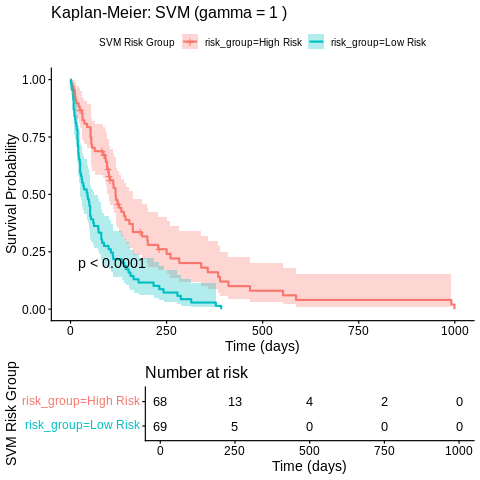

In [26]:
%%R
# Kaplan-Meier plot
library(survminer)
km_final <- survfit(Surv(time, event) ~ risk_group, data = veteran_clean)

ggsurvplot(
  km_final,
  data = veteran_clean,
  pval = TRUE,
  conf.int = TRUE,
  risk.table = TRUE,
  legend.title = "SVM Risk Group",
  title = paste("Kaplan-Meier: SVM (gamma =", best_gamma, ")"),
  xlab = "Time (days)",
  ylab = "Survival Probability"
)

### Plot C-index vs. Gamma

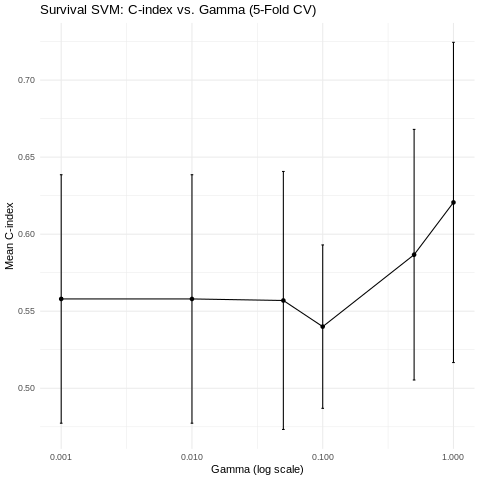

In [27]:
%%R

ggplot(results, aes(x = gamma, y = mean_cindex)) +
  geom_line(group = 1) +
  geom_point() +
  geom_errorbar(aes(ymin = mean_cindex - sd_cindex,
                    ymax = mean_cindex + sd_cindex),
                width = 0.02) +
  scale_x_log10() +
  labs(
    title = "Survival SVM: C-index vs. Gamma (5-Fold CV)",
    x = "Gamma (log scale)",
    y = "Mean C-index"
  ) +
  theme_minimal()

## Summary and Conclusion


Survival SVM is a powerful alternative to traditional survival models, especially for complex, high-dimensional data. However, it requires careful tuning and may not scale well to very large datasets. This tutorial demonstrated its implementation in R using the `survivalsvm` package, along with hyperparameter tuning via cross-validation. At the end, we visualized risk stratification using Kaplan-Meier curves and evaluated model performance using the C-index.


##  Resources


1. Van Belle, V., Pelcmans, K., Van Huffel S. and Suykens J. A.K. (2011a). Improved performance on high-dimensional survival data by application of Survival-SVM. Bioinformatics (Oxford, England) 27, 87-94.

2. Van Belle, V., Pelcmans, K., Van Huffel S. and Suykens J. A.K. (2011b). Support vector methods for survival analysis: a comparaison between ranking and regression approaches. Artificial Intelligence in medecine 53, 107-118.

3.  Fouodo K. C. J. and König I. R. and Weihs C. and Ziegler A. and Wright M. N. (2018) Support Vector Machines for Survival Analysis with R. The R Journal 10, 412-423.